### HCDS_(Fall_2017)
#### A2 Assignments
### A2: Bias in data
by Abhishek Anand 

The goal for project is to explore the concept of 'bias' through data on Wikipedia articles . 

### Step 1  : Getting the article and population data
 
Source : 
    * Wikipedia Data Set : Politicians by Country from the English-language Wikipedia  [https://figshare.com/articles/Untitled_Item/5513449] : File Name  - page_data.csv  
        1. "country", containing the sanitised country name, extracted from the category name;
        2. "page", containing the unsanitised page title.
        3. "last_edit", containing the edit ID of the last edit to the page.
    * Population Data : http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14   File Name  - opulation Mid-2015.csv
    * Article quality predictions : https://ores.wikimedia.org/v3/#!/scoring/get_v3_scores_context_revid_model 

In [2]:
## getting the data from the CSV files
import csv

In [3]:
# Data Source 1 : 
# reading data and saving in dictionary of dictionaries
'''
{
    "revision_id": {
        "country": "",
        "article_name": "",
        "revision_id":"",
    },
    "revision_id": {
    
    },
    ...
}
'''

page_data = dict()
skip_lines = 1

with open('page_data.csv', encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        #page_data.append([row[0],row[1],row[2]])
        #['Template:ZambiaProvincialMinisters', 'Zambia', '235107991']
        if(skip_lines!=1):
            revision_id = row[2]
            page_data[revision_id]=dict()
            page_data[revision_id]["country"] = row[1]
            page_data[revision_id]["article_name"] = row[0]
            page_data[revision_id]["revision_id"] = row[2] 
            
        skip_lines = skip_lines+1
# print(page_data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [4]:
# Data Source 2 : 
'''
{
    "country_name_1":"population",
    "country_name_1":"population"
}

'''
population_data = {}

# skip twolines from input csv file 
skip_lines = 1
with open('Population Mid-2015.csv', encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # last line in the raw data file is an empty line
        # skip_lines > 2 skips first two lines
        # row checks if the read list is empty
        #print(row)
        if(skip_lines>3 and row):
            # ['Afghanistan', 'Country', 'Mid-2015', 'Number', '32,247,000', '']
            population_data[row[0]] = row[4]
        skip_lines = skip_lines + 1
        
print(population_data)

{'Afghanistan': '32,247,000', 'Albania': '2,892,000', 'Algeria': '39,948,000', 'Andorra': '78,000', 'Angola': '25,000,000', 'Antigua and Barbuda': '90,000', 'Argentina': '42,426,000', 'Armenia': '3,017,106', 'Australia': '23,888,000', 'Austria': '8,615,955', 'Azerbaijan': '9,651,000', 'Bahamas': '377,000', 'Bahrain': '1,412,299', 'Bangladesh': '160,411,000', 'Barbados': '278,000', 'Belarus': '9,524,247', 'Belgium': '11,211,064', 'Belize': '368,000', 'Benin': '10,583,034', 'Bhutan': '757,000', 'Bolivia': '10,475,500', 'Bosnia-Herzegovina': '3,650,114', 'Botswana': '2,139,900', 'Brazil': '204,519,398', 'Brunei': '413,000', 'Bulgaria': '7,181,000', 'Burkina Faso': '18,450,400', 'Burundi': '10,742,000', 'Cambodia': '15,417,100', 'Cameroon': '23,739,000', 'Canada': '35,833,000', 'Cape Verde': '514,000', 'Central African Republic': '5,551,900', 'Chad': '13,707,000', 'Channel Islands': '164,000', 'Chile': '18,025,000', 'China': '1,371,920,000', 'Colombia': '48,218,000', 'Comoros': '764,000', 

In [5]:
# Merging data set from wikipedia data(page_data) and population data(population_data)
# reading data from page_data and including poulation data
'''
{
    "revision_id": {
        "country": "",
        "article_name": "",
        "revision_id":"",
        "population":""
    },
    "revision_id": {
    
    },
    ...
}
'''
count=0
for key,value in page_data.items():
    revision_id = key
    #print(key)
    
    country_page_data = value["country"]
    #print(country_page_data)
    
    if population_data.get(str(country_page_data)) is not None:
        page_data[revision_id]["population"] = population_data[country_page_data]
    else:
        # for now setting population as 0 for countries which are not preset in population_data
        page_data[revision_id]["population"] = 0
        count = count+1
        
#print("no of entries which have popluation 0")      
#print(count)



no of entries which have popluation  = 0
1398


### Getting article quality predictions

In [6]:
# Data Source 3 : 
import requests
import json

headers = {'User-Agent' : 'https://github.com/abhishekanand', 'From' : 'anand1@uw.edu'}

def get_ores_data(revision_ids, headers):
    
    # Define the endpoint
    endpoint = 'https://ores.wikimedia.org/v3/scores/{project}/?models={model}&revids={revids}'
    
    # Specify the parameters - smushing all the revision IDs together separated by | marks.
    # Yes, 'smush' is a technical term, trust me I'm a scientist.
    # What do you mean "but people trusting scientists regularly goes horribly wrong" who taught you tha- oh.  
    params = {'project' : 'enwiki',
              'model'   : 'wp10',
              'revids'  : '|'.join(str(x) for x in revision_ids)
              }
    api_call = requests.get(endpoint.format(**params))
    response = api_call.json()
    json.dumps(response, indent=4, sort_keys=True)
    #print(response)
    return response


# So if we grab some example revision IDs and turn them into a list and then call get_ores_data...
#example_ids = [783381498, 807355596, 757539710]
#get_ores_data(example_ids, headers)


#get_ores_data(example_ids, headers)
no_revision_ids = len(page_data)
#print(no_revision_ids)

# getting all the revision ids from page_data in list format
revision_ids = list(page_data.keys())


counter = 0
call_count = 0

# this contains revsion id as key and article quality as value
data_revision_quality  = {}



# prediction is being added in page_data
'''
{
    "revision_id": {
        "country": "",
        "article_name": "",
        "revision_id":"",
        "population":"",
        "article_quality":""
    },
    "revision_id": {
    
    },
    ...
}
'''

while(counter<no_revision_ids):
    temp = get_ores_data(revision_ids[counter:counter+100], headers)
    hundred_revisions = temp["enwiki"]["scores"]
    
    for key, value in hundred_revisions.items():
        revision = key
        if value["wp10"].get("score") is not None:
            prediction = value["wp10"]["score"]["prediction"]
            page_data[revision]["article_quality"] = prediction
            #print(page_data[revision])
        else:
            page_data[revision]["article_quality"] = 'NA'
        
        
    counter = counter + 100
    call_count = call_count + 1
    
    
if(counter>no_revision_ids):
    temp = get_ores_data(revision_ids[counter-100:(counter-100)+no_revision_ids%100], headers)
    left_revisions = temp["enwiki"]["scores"]
    
    counter = counter-100
    call_count = call_count + 1
    
    for key, value in left_revisions.items():
        revision = key
        counter = counter + 1
        if value["wp10"].get("score") is not None:
            prediction = value["wp10"]["score"]["prediction"]
            page_data[revision]["article_quality"] = prediction
            #print(page_data[revision])

    

47197


In [7]:
#print(counter)  # Numbe of entries received from the API Call 
#print(call_count)
#print(no_revision_ids%100)

47197
473
97


In [8]:
# Cleaning Data Set to contain following values only 
    #country
    #article_name
    #revision_id
    #article_quality
    #population

    
combined_data = [] # Empty List 
for key, value in page_data.items():
    combined_data.append(value)
    
'''
printing first 100 revision ids because of 
"OPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`."
'''
for i in range(100):    
    print(combined_data[i])
    

{'country': 'Zambia', 'article_name': 'Template:ZambiaProvincialMinisters', 'revision_id': '235107991', 'population': '15,473,900', 'article_quality': 'Stub'}
{'country': 'Chad', 'article_name': 'Bir I of Kanem', 'revision_id': '355319463', 'population': '13,707,000', 'article_quality': 'Stub'}
{'country': 'Zimbabwe', 'article_name': 'Template:Zimbabwe-politician-stub', 'revision_id': '391862046', 'population': '17,354,000', 'article_quality': 'Stub'}
{'country': 'Uganda', 'article_name': 'Template:Uganda-politician-stub', 'revision_id': '391862070', 'population': '40,141,000', 'article_quality': 'Stub'}
{'country': 'Namibia', 'article_name': 'Template:Namibia-politician-stub', 'revision_id': '391862409', 'population': '2,482,100', 'article_quality': 'Stub'}
{'country': 'Nigeria', 'article_name': 'Template:Nigeria-politician-stub', 'revision_id': '391862819', 'population': '181,839,400', 'article_quality': 'Stub'}
{'country': 'Colombia', 'article_name': 'Template:Colombia-politician-st

In [9]:
# The final data file should be named: en-wikipedia_traffic_200801-201709.csv
import csv
CSVOut = "bias_in_data.csv"
with open(CSVOut, "w",encoding="utf-8") as ofile:
    ofile.write("country" + "," + "article_name" + "," + "revision_id"+"," + "article_quality"+"," + "population"+ "\n")
    for item in combined_data:
        #print(item["article_quality"])
        #print(str(item["population"]).replace(',',''))
        ofile.write(str(item["country"]).replace(',','') + "," + str(item["article_name"]).replace(',','') + "," + str(item["revision_id"])+"," + str(item["article_quality"])+"," + str(item["population"]).replace(',','') + "\n")
print("Done")    

Done


### Analysis

FA - Featured article
GA - Good article
B - B-class article
C - C-class article
Start - Start-class article
Stub - Stub-class article

####  if a country has a population of 10,000 people, and you found 10 articles about politicians from that country, then the percentage of articles-per-population would be .1%.

In [10]:
# Creating dataset Country and Article Count  
'''
{
    "country_name_1":"Count of Articles",
    "country_name_1":"Count of Articles"
}

'''

country_articleCount = {}

for item in combined_data:
    country_name = str(item["country"]).replace(',','')
    if (country_name in country_articleCount.keys()):
        if(item["article_name"]) is not None:
            country_articleCount[country_name]=country_articleCount[country_name]+1
    else:
        country_articleCount[country_name]=0
        if(item["article_name"]) is not None:
            country_articleCount[country_name]=1
        
print(country_articleCount)

{'Zambia': 26, 'Chad': 100, 'Zimbabwe': 167, 'Uganda': 188, 'Namibia': 165, 'Nigeria': 684, 'Colombia': 288, 'Chile': 352, 'Fiji': 199, 'Solomon Islands': 98, 'Palestinian Territory': 183, 'Somalia': 339, 'Cambodia': 217, 'Slovakia': 119, 'Slovenia': 59, 'Afghanistan': 327, 'Iraq': 302, 'Nepal': 363, 'Sri Lanka': 465, 'Laos': 109, 'Albania': 460, 'Costa Rica': 150, 'Hondura': 189, 'Czech Republic': 254, 'Canada': 852, 'Tunisia': 140, 'Guatemala': 84, 'Burkina Faso': 97, 'Angola': 110, 'Panama': 109, 'Japan': 441, 'Indonesia': 215, 'Madagascar': 240, 'Malaysia': 391, 'Gabon': 103, 'Germany': 703, 'Liberia': 158, 'Ghana': 395, 'Peru': 354, 'Argentina': 496, 'Spain': 881, 'South Africa': 382, 'Egypt': 239, 'Nicaragua': 116, 'Bangladesh': 324, 'India': 990, 'Iran': 832, 'Philippines': 515, 'Turkey': 353, 'Austria': 340, 'Azerbaijan': 182, 'Haiti': 166, 'Greece': 311, 'Hungary': 614, 'Iceland': 206, 'Moldova': 426, 'Romania': 348, 'Poland': 809, 'Luxembourg': 180, 'Denmark': 291, 'Kenya': 3

In [11]:
# Population Data 
# print(population_data)
# Creating dataste containining Country and Population 
'''
{
    "country_name_1":"Population",
    "country_name_1":"Population"
}

'''

country_population= {}

for key, value in population_data.items():
    countryName = str(key).replace(',','')
    country_population[countryName] = str(population_data[key]).replace(',','')
        
print(country_population)

{'Afghanistan': '32247000', 'Albania': '2892000', 'Algeria': '39948000', 'Andorra': '78000', 'Angola': '25000000', 'Antigua and Barbuda': '90000', 'Argentina': '42426000', 'Armenia': '3017106', 'Australia': '23888000', 'Austria': '8615955', 'Azerbaijan': '9651000', 'Bahamas': '377000', 'Bahrain': '1412299', 'Bangladesh': '160411000', 'Barbados': '278000', 'Belarus': '9524247', 'Belgium': '11211064', 'Belize': '368000', 'Benin': '10583034', 'Bhutan': '757000', 'Bolivia': '10475500', 'Bosnia-Herzegovina': '3650114', 'Botswana': '2139900', 'Brazil': '204519398', 'Brunei': '413000', 'Bulgaria': '7181000', 'Burkina Faso': '18450400', 'Burundi': '10742000', 'Cambodia': '15417100', 'Cameroon': '23739000', 'Canada': '35833000', 'Cape Verde': '514000', 'Central African Republic': '5551900', 'Chad': '13707000', 'Channel Islands': '164000', 'Chile': '18025000', 'China': '1371920000', 'Colombia': '48218000', 'Comoros': '764000', 'Congo': '4755000', 'Congo Dem. Rep. of': '73340200', 'Costa Rica': '

In [12]:
# Creating Country : Proportion  (Number of Article for politicians from a country /Country's Population )
# country_articleCount 
# country_population

'''
{
    "country_name_1":"Proportion",
    "country_name_2":"Proportion"
}

'''

article_proportion  = {}

for key, value in country_articleCount.items():
    if (key in country_population.keys()):
        article_proportion[key] = (int(country_articleCount[key])/int(country_population[key])*100)
    
print (article_proportion)

{'Zambia': 0.00016802486768041668, 'Chad': 0.0007295542423579193, 'Zimbabwe': 0.0009623141638815259, 'Uganda': 0.0004683490695299071, 'Namibia': 0.006647596793038153, 'Nigeria': 0.00037615610258282857, 'Colombia': 0.000597287320087934, 'Chile': 0.0019528432732316228, 'Fiji': 0.02295271049596309, 'Solomon Islands': 0.015267175572519085, 'Palestinian Territory': 0.004083732129487782, 'Somalia': 0.003047738919356289, 'Cambodia': 0.0014075280046182486, 'Slovakia': 0.002193932173572852, 'Slovenia': 0.0028585271317829457, 'Afghanistan': 0.0010140478184017118, 'Iraq': 0.0008149827288428326, 'Nepal': 0.0012946253432718714, 'Sri Lanka': 0.0022282067009123667, 'Laos': 0.001579012404518641, 'Albania': 0.015905947441217153, 'Costa Rica': 0.003104304635761589, 'Czech Republic': 0.00240730296106794, 'Canada': 0.0023776965367119695, 'Tunisia': 0.001269726101940867, 'Guatemala': 0.0005190390955076425, 'Burkina Faso': 0.0005257338594285219, 'Angola': 0.00044, 'Panama': 0.0027386934673366836, 'Japan': 0

### if a country has 10 articles about politicians, and 2 of them are FA or GA class articles, then the percentage of high-quality articles would be 20%.

In [13]:
# Creating Creating Country : Proportion    
# Combined Data 
# country_hqarticle
# Creating dataste containining Country and Count of High Quality  Articles  
'''
{
    "country_name_1":"Count High Quality Article",
    "country_name_1":"Count High Quality Article"
}

'''

country_hqarticle = {}

for item in combined_data:
    country_name = str(item["country"]).replace(',','')
    #print(country_name)
    if (country_name in country_hqarticle.keys()):
        if(str(item["article_quality"]) is 'FA' or str(item["article_quality"]) == 'GA'):
            country_hqarticle[country_name]=country_hqarticle[country_name]+1
    else:
        country_hqarticle[country_name]=0
        
print(country_hqarticle)

{'Zambia': 0, 'Chad': 1, 'Zimbabwe': 1, 'Uganda': 1, 'Namibia': 1, 'Nigeria': 4, 'Colombia': 3, 'Chile': 3, 'Fiji': 0, 'Solomon Islands': 0, 'Palestinian Territory': 10, 'Somalia': 8, 'Cambodia': 4, 'Slovakia': 2, 'Slovenia': 1, 'Afghanistan': 12, 'Iraq': 7, 'Nepal': 0, 'Sri Lanka': 8, 'Laos': 1, 'Albania': 5, 'Costa Rica': 0, 'Hondura': 0, 'Czech Republic': 1, 'Canada': 18, 'Tunisia': 1, 'Guatemala': 5, 'Burkina Faso': 2, 'Angola': 1, 'Panama': 4, 'Japan': 8, 'Indonesia': 8, 'Madagascar': 2, 'Malaysia': 6, 'Gabon': 2, 'Germany': 8, 'Liberia': 2, 'Ghana': 4, 'Peru': 1, 'Argentina': 11, 'Spain': 9, 'South Africa': 11, 'Egypt': 7, 'Nicaragua': 0, 'Bangladesh': 3, 'India': 12, 'Iran': 15, 'Philippines': 17, 'Turkey': 4, 'Austria': 3, 'Azerbaijan': 2, 'Haiti': 5, 'Greece': 2, 'Hungary': 3, 'Iceland': 2, 'Moldova': 0, 'Romania': 10, 'Poland': 8, 'Luxembourg': 1, 'Denmark': 3, 'Kenya': 5, 'Ecuador': 2, 'Salvadoran': 1, 'Finland': 0, 'Portugal': 3, 'Switzerland': 0, 'Sweden': 3, 'Belgium': 0,

In [14]:
# Creating Country and High Quality Article proportion (Number of High quality Article /Country's Population )
# country_articleCount 
# country_hqarticle

'''
{
    "country_name_1":"HqProportion",
    "country_name_2":"hqProportion"
}

'''

hqarticle_proportion  = {}

for key, value in country_articleCount.items():
    if (key in country_hqarticle.keys() and str(country_hqarticle[key]) != '0' ):
        #print(country_hqarticle[key])
        #print(country_articleCount[key])
        hqarticle_proportion[key] = (int(country_hqarticle[key])/int(country_articleCount[key])*100)
        #hqarticle_proportion[key]
        
print (hqarticle_proportion)


{'Chad': 1.0, 'Zimbabwe': 0.5988023952095809, 'Uganda': 0.5319148936170213, 'Namibia': 0.6060606060606061, 'Nigeria': 0.5847953216374269, 'Colombia': 1.0416666666666665, 'Chile': 0.8522727272727272, 'Palestinian Territory': 5.46448087431694, 'Somalia': 2.359882005899705, 'Cambodia': 1.8433179723502304, 'Slovakia': 1.680672268907563, 'Slovenia': 1.694915254237288, 'Afghanistan': 3.669724770642202, 'Iraq': 2.3178807947019866, 'Sri Lanka': 1.7204301075268817, 'Laos': 0.9174311926605505, 'Albania': 1.0869565217391304, 'Czech Republic': 0.39370078740157477, 'Canada': 2.112676056338028, 'Tunisia': 0.7142857142857143, 'Guatemala': 5.952380952380952, 'Burkina Faso': 2.0618556701030926, 'Angola': 0.9090909090909091, 'Panama': 3.669724770642202, 'Japan': 1.8140589569160999, 'Indonesia': 3.7209302325581395, 'Madagascar': 0.8333333333333334, 'Malaysia': 1.5345268542199488, 'Gabon': 1.9417475728155338, 'Germany': 1.1379800853485065, 'Liberia': 1.2658227848101267, 'Ghana': 1.0126582278481013, 'Peru'

###  Visualization
The visualization should be pretty straightforward. Produce four visualizations that show:

10 highest-ranked countries in terms of number of politician articles as a proportion of country population
10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country
10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

In [15]:
# 10 highest-ranked countries in terms of number of politician articles as a proportion of country population

import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline


In [16]:
# sorts article_proportion dictionary in descending order
sorted_descending_article_proportion = [(k, article_proportion[k]) for k in sorted(article_proportion, key=article_proportion.get, reverse=True)]
#for k, v in sorted_top_10_article_proportion:
   # print(k, v)

sorted_top_10_article_proportion={}
count =0
for k, v in sorted_descending_article_proportion:
    count =count+1
    sorted_top_10_article_proportion[k] =v
    if count==10:
        break
print(sorted_top_10_article_proportion)
    


{'Nauru': 0.4880294659300184, 'Tuvalu': 0.46610169491525427, 'San Marino': 0.24848484848484848, 'Monaco': 0.10501995379122034, 'Liechtenstein': 0.07718924673941975, 'Marshall Islands': 0.06727272727272728, 'Iceland': 0.06226800633561851, 'Tonga': 0.06098741529525654, 'Andorra': 0.04358974358974359, 'Federated States of Micronesia': 0.036893203883495145}


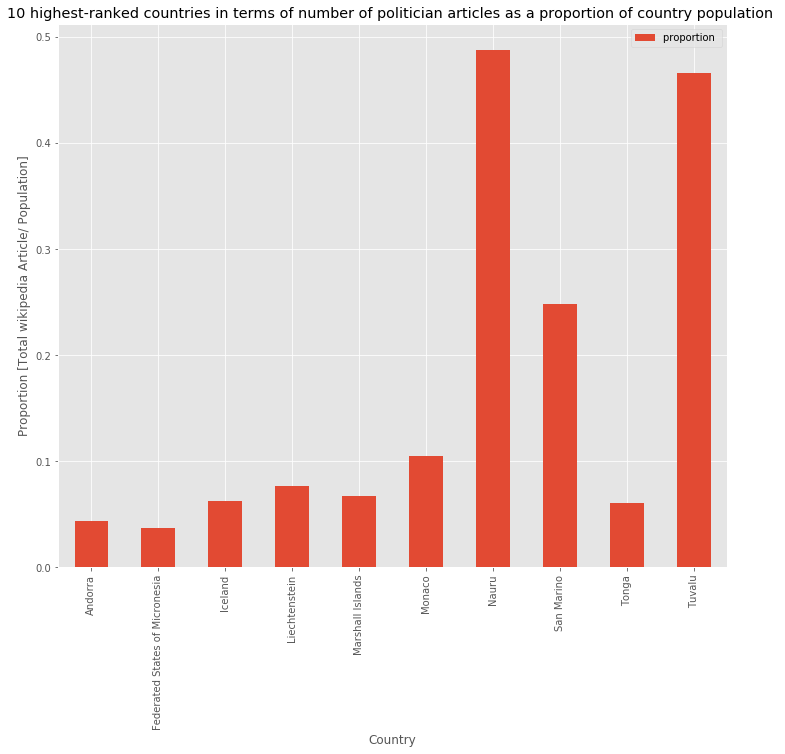

In [17]:
# https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe 
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html 
ad= pd.Series(sorted_top_10_article_proportion) 
adata = {'proportion ':ad}
adf = pd.DataFrame(adata)
adf
adf.plot(kind='bar',figsize=(12,10) )
plt.xlabel('Country')
plt.ylabel('Proportion [Total wikipedia Article/ Population]')

plt.title('10 highest-ranked countries in terms of number of politician articles as a proportion of country population ')
plt.show()

In [34]:
print("10 highest-ranked countries in terms of number of politician articles as a proportion of country population")
print("")



print("COUNTRY                          PROPORTION")
print("-------------------------------------------")
print (ad.to_string(index=True))

10 highest-ranked countries in terms of number of politician articles as a proportion of country population

COUNTRY                          PROPORTION
-------------------------------------------
Andorra                           0.043590
Federated States of Micronesia    0.036893
Iceland                           0.062268
Liechtenstein                     0.077189
Marshall Islands                  0.067273
Monaco                            0.105020
Nauru                             0.488029
San Marino                        0.248485
Tonga                             0.060987
Tuvalu                            0.466102


In [19]:
# 10 lowest-ranked countries in terms of number of politician articles as a proportion of country population
# sorts article_proportion dictionary in ascending order
sorted_ascending_article_proportion = [(k, article_proportion[k]) for k in sorted(article_proportion, key=article_proportion.get, reverse=False)]
#for k, v in sorted_bottom_10_article_proportion:
    #print(k, v)

sorted_bottom_10_article_proportion={}
count =0
for k, v in sorted_ascending_article_proportion:
    count =count+1
    sorted_bottom_10_article_proportion[k] =v
    if count==10:
        break
print(sorted_bottom_10_article_proportion)

{'India': 7.533686903819783e-05, 'China': 8.294944311621669e-05, 'Indonesia': 8.406910976635032e-05, 'Uzbekistan': 9.267902495657588e-05, 'Ethiopia': 0.00010698129355666953, 'Korea North': 0.00015610615218348477, 'Zambia': 0.00016802486768041668, 'Thailand': 0.0001719868706451427, 'Congo Dem. Rep. of': 0.00019361823392900483, 'Bangladesh': 0.00020198116089295621}


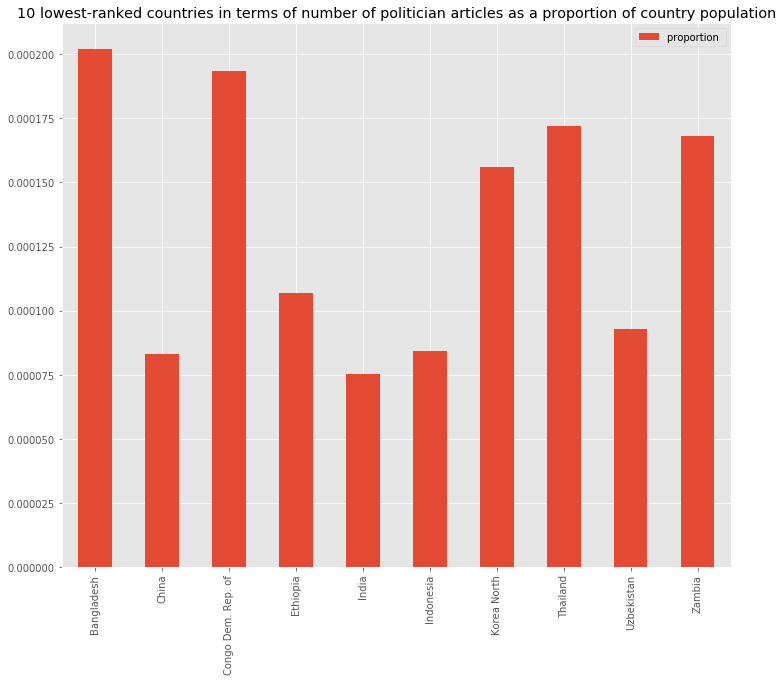

In [20]:
bd = pd.Series(sorted_bottom_10_article_proportion) 
bdata = {'proportion ':bd}
bdf = pd.DataFrame(bdata)
bdf
bdf.plot(kind='bar',figsize=(12,10), title='10 lowest-ranked countries in terms of number of politician articles as a proportion of country population' )

In [21]:



print("10 lowest-ranked countries in terms of number of politician articles as a proportion of country population")
print("")


print("COUNTRY              PROPORTION")
print("--------------------------------")
print (bd.to_string(index=True))

COUNTRY              PROPORTION
--------------------------------
Bangladesh            0.000202
China                 0.000083
Congo Dem. Rep. of    0.000194
Ethiopia              0.000107
India                 0.000075
Indonesia             0.000084
Korea North           0.000156
Thailand              0.000172
Uzbekistan            0.000093
Zambia                0.000168


In [22]:
# 10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles
# about politicians from that country
sorted_descending_articleQ_proportion = [(k, hqarticle_proportion[k]) for k in sorted(hqarticle_proportion, key=hqarticle_proportion.get, reverse=True)]
#for k, v in sorted_top_10_articleQ_proportion:
#      print(k, v)
        

sorted_top_10_articleQ_proportion={}
count =0
for k, v in sorted_descending_articleQ_proportion:
    count =count+1
    sorted_top_10_articleQ_proportion[k] =v
    if count==10:
        break
print(sorted_top_10_articleQ_proportion)

{'Korea North': 17.94871794871795, 'Uzbekistan': 10.344827586206897, 'Saudi Arabia': 10.084033613445378, 'Guinea-Bissau': 9.523809523809524, 'Bhutan': 9.090909090909092, 'Dominica': 8.333333333333332, 'Central African Republic': 7.352941176470589, 'Gambia': 7.317073170731707, 'South African Republic': 6.666666666666667, 'Abkhazia': 6.25}


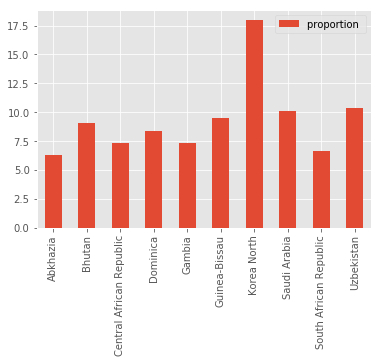

In [23]:
cd = pd.Series(sorted_top_10_articleQ_proportion) 
cdata = {'proportion ':cd}
cdf = pd.DataFrame(cdata)
#cdf = cdf.sort('propotion')
cdf.plot(kind='bar' )

In [24]:


print("10 highest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country")
print("")
print("COUNTRY                      Percentage")
print("----------------------------------------")
print (cd.to_string(index=True))

COUNTRY                      Percentage
----------------------------------------
Abkhazia                     6.250000
Bhutan                       9.090909
Central African Republic     7.352941
Dominica                     8.333333
Gambia                       7.317073
Guinea-Bissau                9.523810
Korea North                 17.948718
Saudi Arabia                10.084034
South African Republic       6.666667
Uzbekistan                  10.344828


In [25]:
# 10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles
# about politicians from that country
sorted_ascending_articleQ_proportion = [(k, hqarticle_proportion[k]) for k in sorted(hqarticle_proportion, key=hqarticle_proportion.get, reverse=False)]
#for k, v in sorted_bottom_10_articleQ_proportion:
      #print(k, v)
        
sorted_bottom_10_articleQ_proportion={}
count =0
for k, v in sorted_ascending_articleQ_proportion:
    count =count+1
    sorted_bottom_10_articleQ_proportion[k] =v
    if count==10:
        break
print(sorted_bottom_10_articleQ_proportion)

{'Tanzania': 0.24509803921568626, 'Peru': 0.2824858757062147, 'Czech Republic': 0.39370078740157477, 'Lithuania': 0.4032258064516129, 'Serbia': 0.45454545454545453, 'Norway': 0.4559270516717325, 'Mexico': 0.46253469010175763, 'Morocco': 0.4807692307692308, 'Italy': 0.4830917874396135, 'Hungary': 0.4885993485342019}


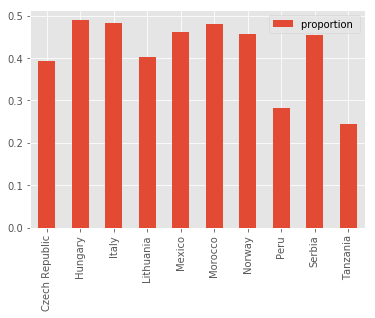

In [26]:
dd = pd.Series(sorted_bottom_10_articleQ_proportion) 
ddata = {'proportion ':dd}
ddf = pd.DataFrame(ddata)
ddf
ddf.plot(kind='bar' )

In [35]:
print("10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country")
print("")

print("COUNTRY         Percentage")
print("---------------------------")
print (dd.to_string(index=True))

10 lowest-ranked countries in terms of number of GA and FA-quality articles as a proportion of all articles about politicians from that country

COUNTRY         Percentage
---------------------------
Czech Republic    0.393701
Hungary           0.488599
Italy             0.483092
Lithuania         0.403226
Mexico            0.462535
Morocco           0.480769
Norway            0.455927
Peru              0.282486
Serbia            0.454545
Tanzania          0.245098


## Playing Around 

In [28]:
Final_data = {'Top10':ad,
             'Bottom 10':bd,
              'Top10HQ':cd,
             'botton10HQ':dd}
Final_data_f = pd.DataFrame(Final_data)
Final_data_f

,Bottom 10,Top10,Top10HQ,botton10HQ
Abkhazia,NaN,NaN,6.250000,NaN
Andorra,NaN,0.043590,NaN,NaN
Bangladesh,0.000202,NaN,NaN,NaN
Bhutan,NaN,NaN,9.090909,NaN
Central African Republic,NaN,NaN,7.352941,NaN
China,0.000083,NaN,NaN,NaN
Congo Dem. Rep. of,0.000194,NaN,NaN,NaN
Czech Republic,NaN,NaN,NaN,0.393701
Dominica,NaN,NaN,8.333333,NaN
Ethiopia,0.000107,NaN,NaN,NaN


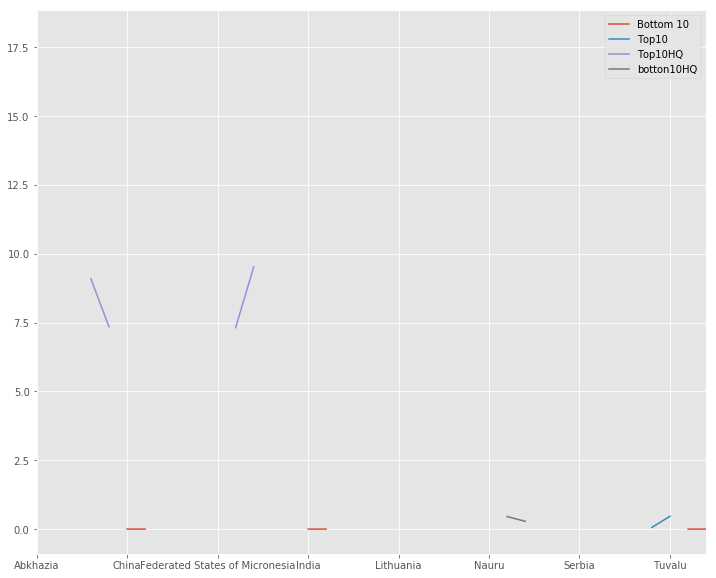

In [29]:
Final_data_f.plot(figsize=(12, 10))



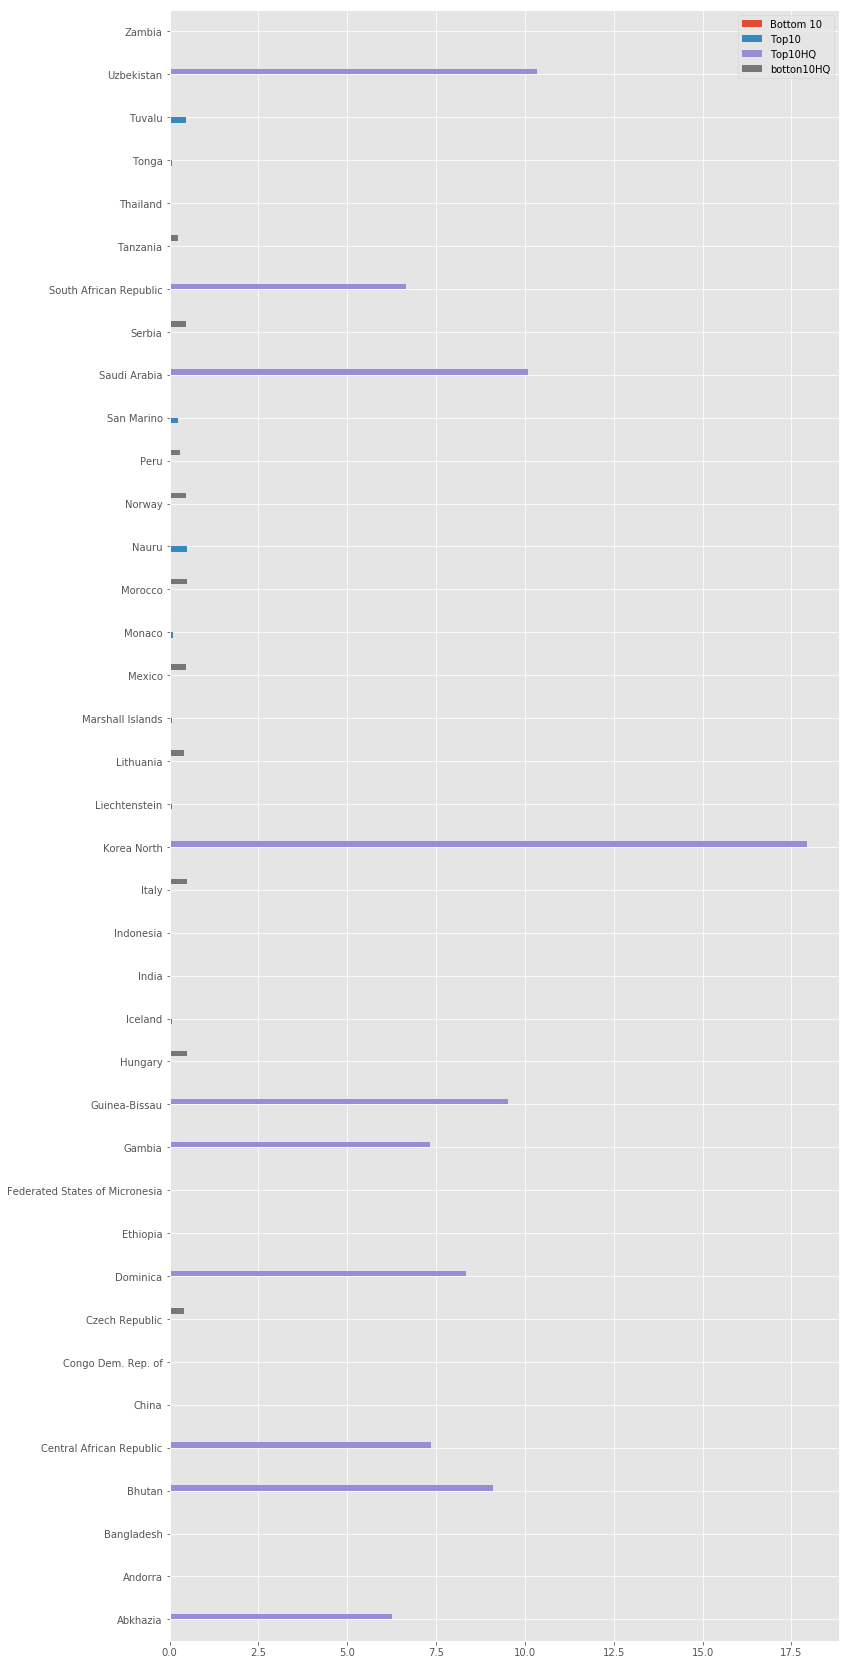

In [30]:
Final_data_f.plot(kind='barh', figsize=(12, 30))

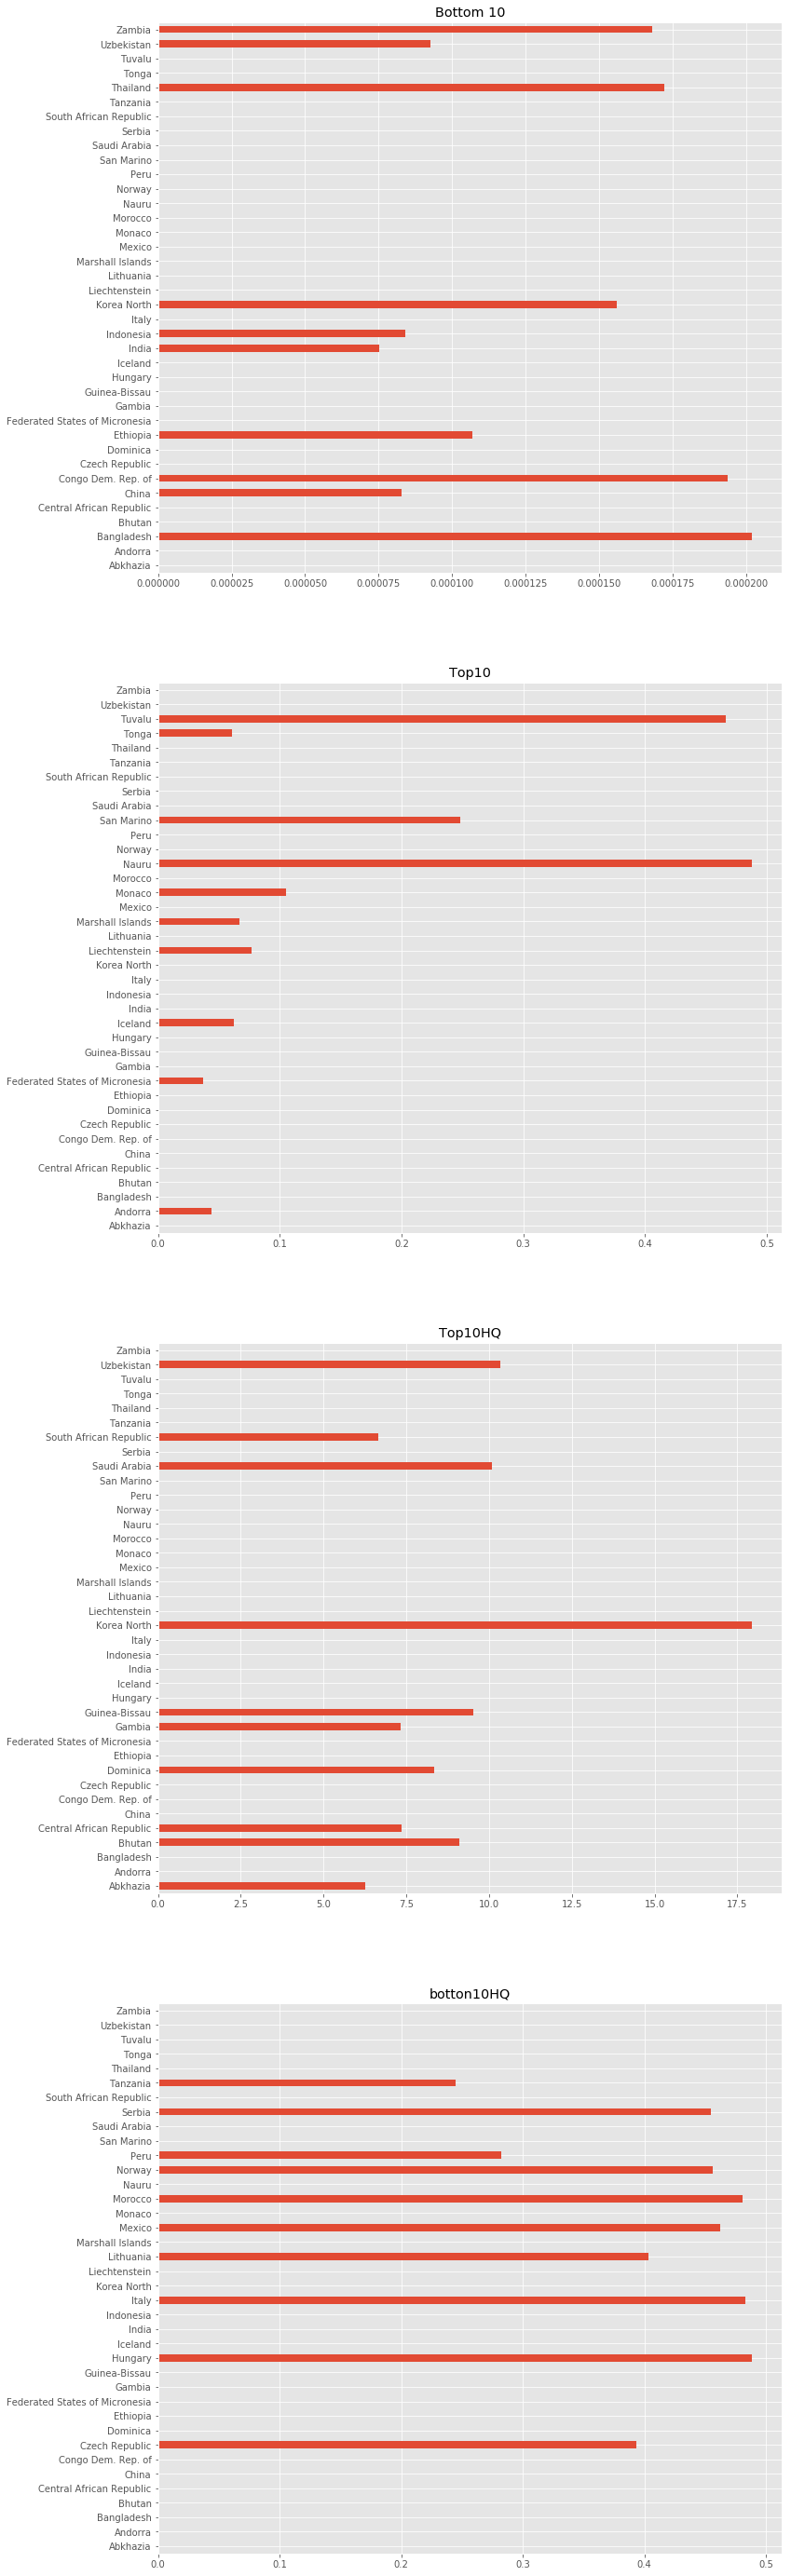

In [31]:
fig, axes = plt.subplots(nrows=4, ncols=1)
for i, c in enumerate(Final_data_f.columns):
    Final_data_f[c].plot(kind='barh',ax=axes[i], figsize=(12,50), title=c)

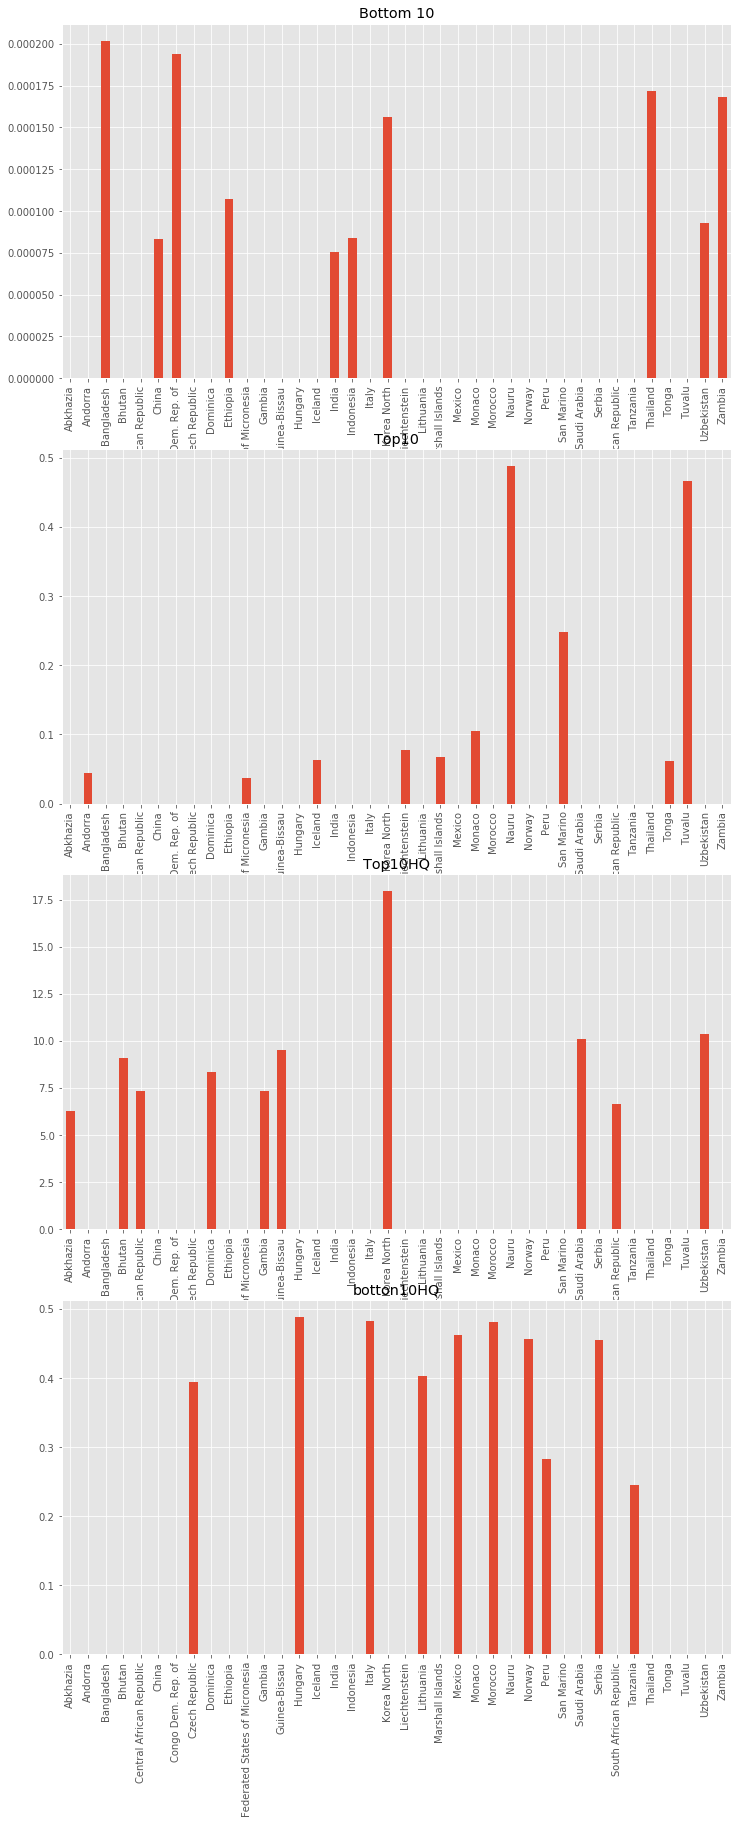

In [32]:
#https://datasciencelab.wordpress.com/2013/12/21/beautiful-plots-with-pandas-and-matplotlib/
fig, axes = plt.subplots(nrows=4, ncols=1)
for i, c in enumerate(Final_data_f.columns):
    Final_data_f[c].plot(kind='bar', ax=axes[i], figsize=(12, 30), title=c)
plt.savefig('All .png', bbox_inches='tight')